In [ ]:
#FetReg plavental segmentation task

In [2]:
import torch
import torch.nn as nn
from builtins import range, zip
import random
from torch.utils.data import Dataset
import numpy
import numpy as np
from copy import deepcopy
from scipy.ndimage import map_coordinates, fourier_gaussian
from scipy.ndimage.filters import gaussian_filter, gaussian_gradient_magnitude
from scipy.ndimage.morphology import grey_dilation
from skimage.transform import resize
from scipy.ndimage.measurements import label as lb
import os 
import pandas as pd
import numpy as np
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# dataloader class and Dataset visualization
def to_one_hot(seg, all_seg_labels=None):
    if all_seg_labels is None:
        all_seg_labels = np.unique(seg)
    result = np.zeros((len(all_seg_labels), *seg.shape), dtype=seg.dtype)
    for i, l in enumerate(all_seg_labels):
        result[i][seg == l] = 1
class FetEndo(Dataset):
    def __init__(self,root,csvpath,trans=None):
        self.root=root
        self.csvpath=csvpath
        self.trans=trans
        self.num_classes=4
        self.img_path_fname_list=[]
        self.mask_path_fname_list=[]
        csvtrain=pd.read_csv(self.csvpath)
        for p in csvtrain['PatientID']:
            #print(p)
            pathf=os.path.join(self.root,p)
            imgspath=os.path.join(pathf,'images')
            maskpath=os.path.join(pathf,'labels')
            Img_list = np.sort(os.listdir(imgspath)) # List all image names
            #print(Img_list)
            for cnt in range(len(Img_list)):
                fname = Img_list[cnt]
                img_path_fname = os.path.join(imgspath, fname)
                mask_path_fname = os.path.join(maskpath, fname)
                self.img_path_fname_list.append(img_path_fname)
                self.mask_path_fname_list.append(mask_path_fname)
                
    def __getitem__(self,idx):
        imgpath=self.img_path_fname_list[idx]
        maskpath=self.mask_path_fname_list[idx]
        image = cv2.imread(imgpath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = resize(image, (256,256), order=1, mode="edge", clip=True, anti_aliasing=False)
        image=(np.asarray(image) / image.max()).astype('float32')
        print(image.max())
        mask = cv2.imread(maskpath, cv2.COLOR_BGR2GRAY)
        mask=self.resize_segmentation(mask.astype(float), (256,256), order=1, cval=0)
        
        if self.trans:
            t = self.trans(image=image, mask=mask)
            image = t['image']
            mask = t['mask'] 
        #img_t=torch.from_numpy(image).float().permute(2,0,1)
        img_t=image
        mask_t=mask
        mask_t = torch.nn.functional.one_hot(torch.from_numpy(mask_t).long(), self.num_classes).permute(2,0,1).float()
        
        return img_t,mask_t
    
    def __len__(self):
        
        return len(self.img_path_fname_list)
    
    def resize_segmentation(self,segmentation, new_shape, order=3, cval=0):
        tpe = segmentation.dtype
        unique_labels = np.unique(segmentation)
        assert len(segmentation.shape) == len(new_shape), "new shape must have same dimensionality as segmentation"
        if order == 0:
            return resize(segmentation.astype(float), new_shape, order, mode="constant", cval=cval, clip=True, anti_aliasing=False).astype(tpe)
        else:
            reshaped = np.zeros(new_shape, dtype=segmentation.dtype)

            for i, c in enumerate(unique_labels):
                mask = segmentation == c
                reshaped_multihot = resize(mask.astype(float), new_shape, order, mode="edge", clip=True, anti_aliasing=False)
                reshaped[reshaped_multihot >= 0.5] = c
            return reshaped 

In [4]:
root='FetReg2021_Task1_Segmentation'
pathtrain='Cvfold'
csvpath=os.path.join(pathtrain,'train_fold1.csv')
scvpathval=os.path.join(pathtrain,'valid_fold1.csv')
x_train_dir,y_train_dir=root,csvpath
x_valid_dir,y_valid_dir=root,scvpathval

In [5]:
from albumentations.pytorch import ToTensorV2
import albumentations as A

trans = A.Compose([
    A.Resize(256, 256),
])
transform_train= A.Compose({
        A.Resize(256, 256),
        A.CenterCrop(256, 256),
        A.HorizontalFlip(p=0.5),
        #A.Rotate(limit=(-90, 90)),
        A.VerticalFlip(p=0.5),
        #A.RandomRotate90(p=0.5),
        # A.OneOf([
        # A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        # A.GridDistortion(p=0.5),
        # A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)], p=0.8),
        #A.CLAHE(p=0.8),
        A.RandomBrightnessContrast(p=0.8),
        A.RandomGamma(p=0.8),
        #A.GridDistortion(p=0.5),
        })

In [8]:
from torch.utils.data import DataLoader
dataset_train = FetEndo(x_train_dir,y_train_dir, trans=transform_train)
dataset_valid = FetEndo(x_valid_dir,y_valid_dir, trans=trans)

dataset_train = FetEndo(x_train_dir,y_train_dir, trans=None)
dataset_valid = FetEndo(x_valid_dir,y_valid_dir, trans=None)
  
dataset=dataset_train
len(dataset) 
imges,masks=dataset[110]
print(imges.shape)
print(masks.shape)
print(imges.dtype)
print(masks.dtype)
print(imges.max())
print(masks.max())
print(imges.min())
print(masks.min())
imgesf=imges[:,:,2]
mask1=masks[1,:,:].numpy()
mask2=masks[2,:,:].numpy()
mask3=masks[3,:,:].numpy()
mask4=masks[0,:,:].numpy()

1.0
(256, 256, 3)
torch.Size([4, 256, 256])
float32
torch.float32
1.0
tensor(1.)
0.0
tensor(0.)


In [9]:
dataset=dataset_valid
len(dataset) 
imges,masks=dataset[0]
print(imges.shape)
print(masks.shape)
print(imges.dtype)
print(masks.dtype)
print(imges.max())
print(masks.max())
print(imges.min())
print(masks.min())

1.0
(256, 256, 3)
torch.Size([4, 256, 256])
float32
torch.float32
1.0
tensor(1.)
0.0
tensor(0.)


1.0


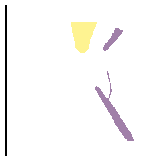

In [10]:
import random
ix = random.randint(0, len(dataset))
img, mask= dataset[ix]
fig, ax = plt.subplots(dpi=50)
ax.imshow(img[0], cmap="gray")
ax.axis('off')
mask = torch.argmax(mask, axis=0).float().numpy()
mask[mask == 0] = np.nan
ax.imshow(mask, alpha=0.5)
plt.show()

In [11]:
data={'train':dataset_train,
      'val':dataset_valid}
## check dataset image shape and mask
imgs, masks = next(iter(data['train']))
imgs.shape, masks.shape

1.0


((256, 256, 3), torch.Size([4, 256, 256]))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


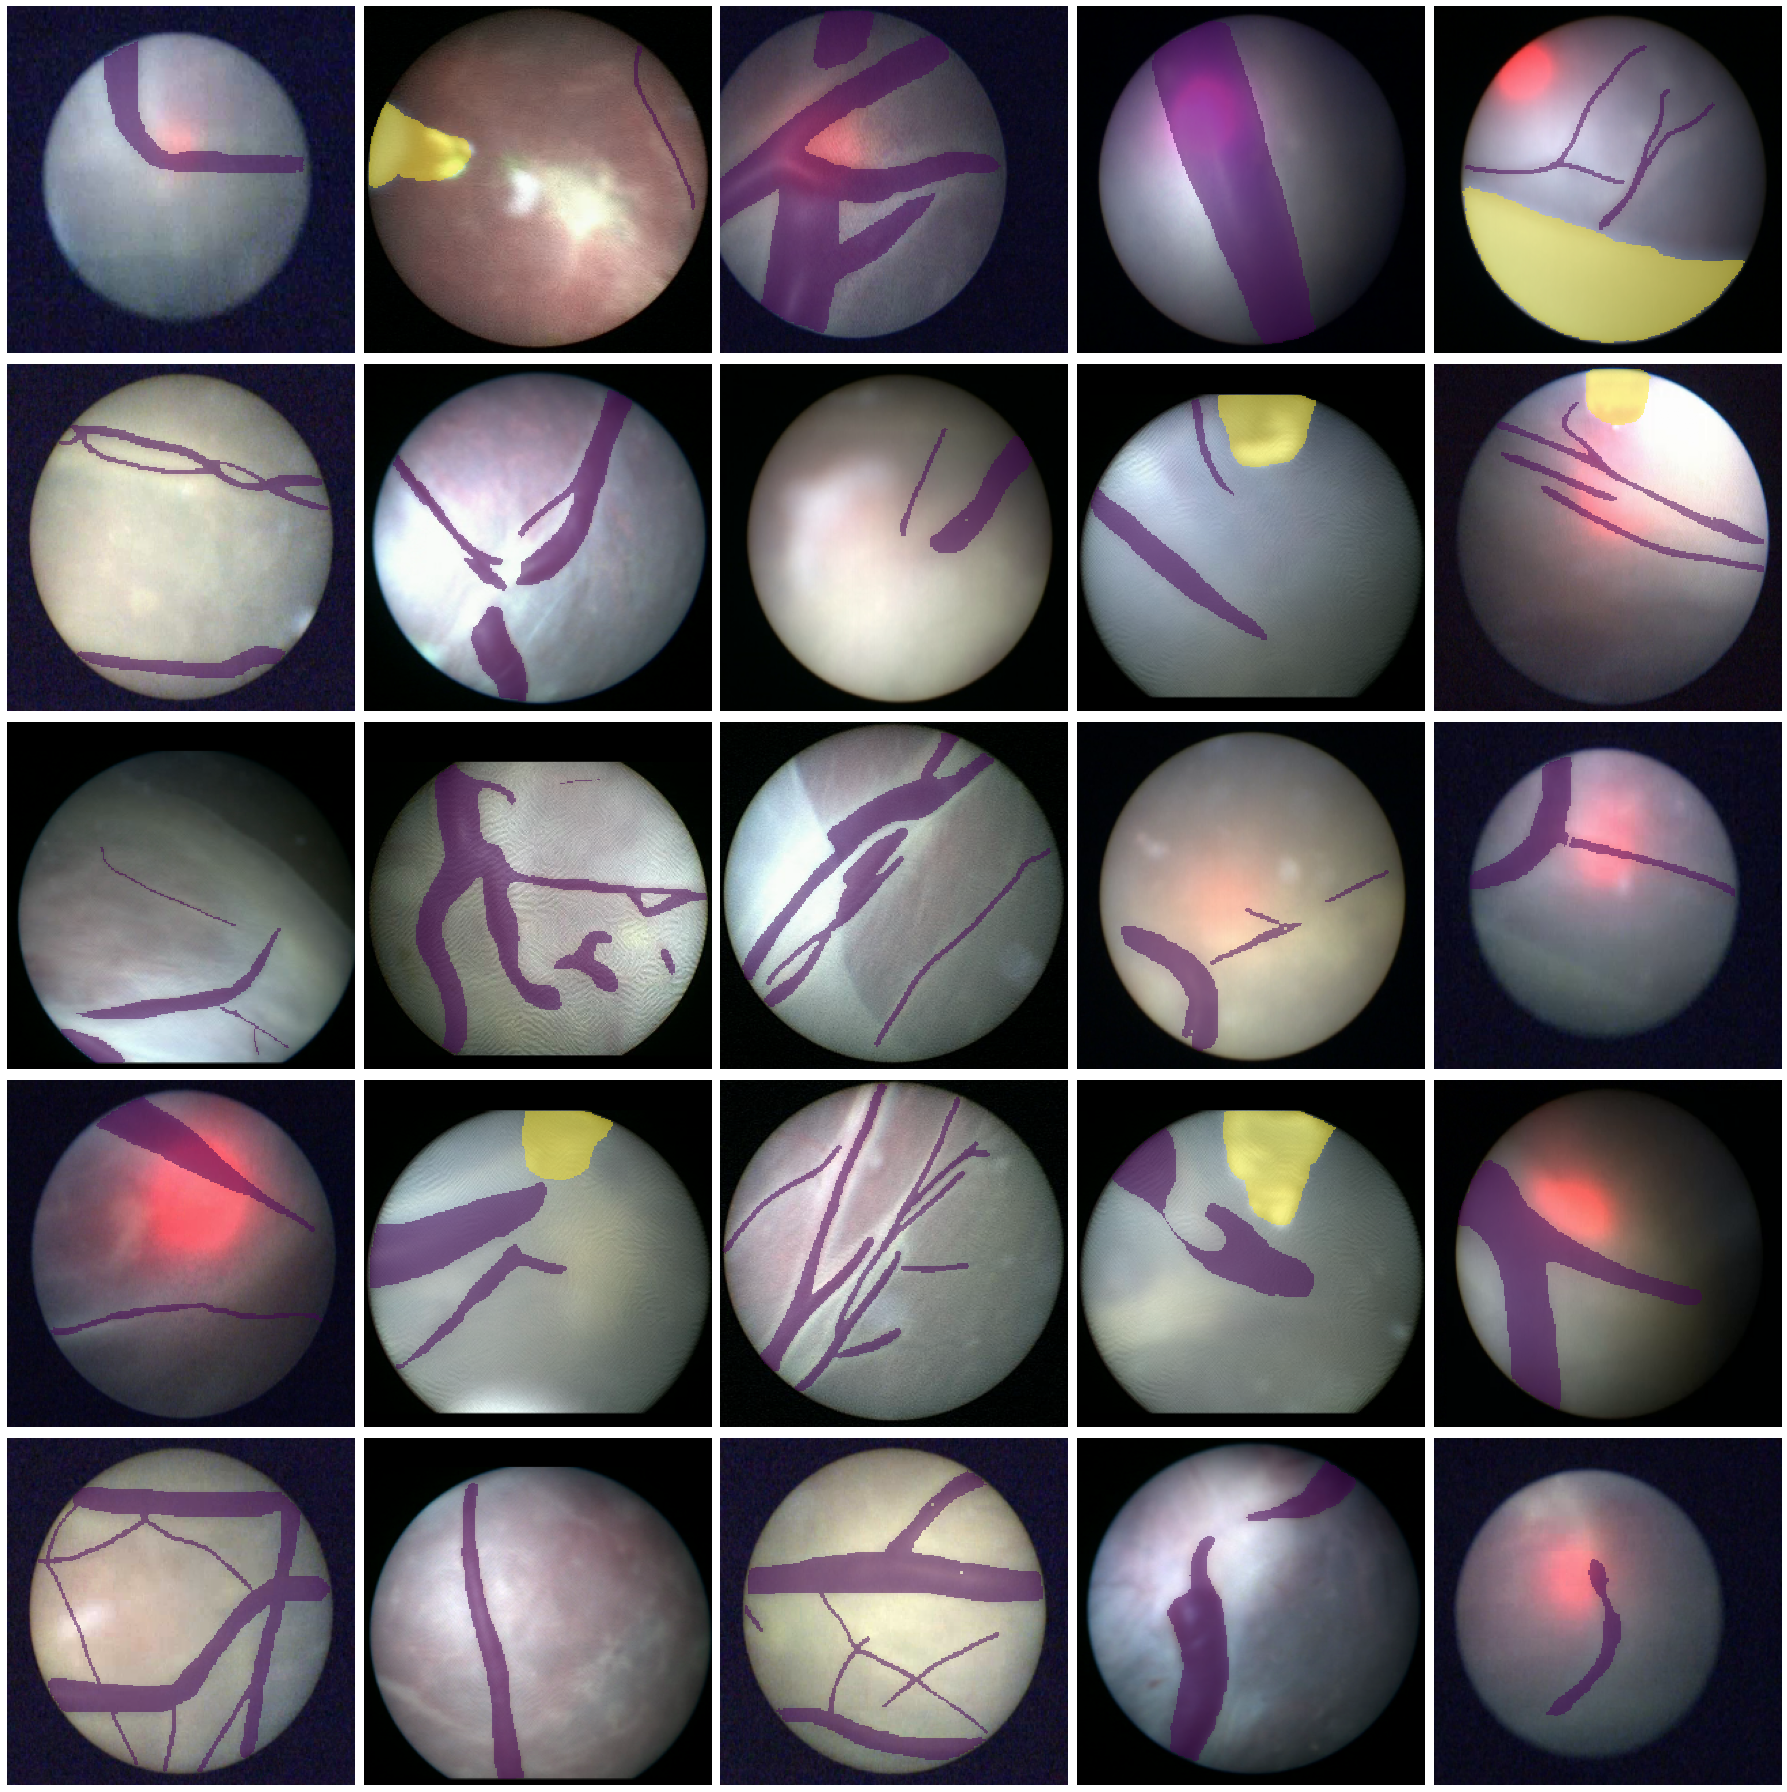

In [12]:

#################### take the batch size and prepare dataloader ######
batch_size=25
dataloader = {
    'train': torch.utils.data.DataLoader(data['train'], batch_size=batch_size, shuffle=True, pin_memory=True),
    'val': torch.utils.data.DataLoader(data['val'], batch_size=batch_size, shuffle=False, pin_memory=True),
}
imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

import matplotlib.pyplot as plt

r, c = 5, 5
fig = plt.figure(figsize=(5*r, 5*c))
for i in range(r):
    for j in range(c):
        ix = c*i + j
        ax = plt.subplot(r, c, ix + 1)
        ax.imshow(imgs[ix].squeeze(0), cmap="gray")
        mask = torch.argmax(masks[ix], axis=0).float().numpy()
        mask[mask == 0] = np.nan
        ax.imshow(mask, alpha=0.5)
        ax.axis('off')
plt.tight_layout()
plt.show()   